In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown
import cv2
import pandas as pd
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

from src.config import Config
from src.utils.inference import ColorizationInference
from src.utils.video import colorize_video
from src.training.metrics import PerceptualMetrics


In [2]:
# Load configuration
cfg = Config("configs/default.yaml")

# Path to your trained checkpoint
checkpoint_path = Path("artifacts/food101_step10_sigma5_T042/train_runs/long_run_45/checkpoints/lpips/best_ep039_lpips0.1575.pt")
# Initialize inference manager
print(f"Loading model from {checkpoint_path}")
print(f"Using device: {cfg.device}")

inference_mgr = ColorizationInference(
    model_path=checkpoint_path,
    centers_path=cfg.centers_path,
    config=cfg.config,
    device=cfg.device
)

print("✓ Inference manager ready!")

Loading model from artifacts/food101_step10_sigma5_T042/train_runs/long_run_45/checkpoints/lpips/best_ep039_lpips0.1575.pt
Using device: cuda
Inference manager initialized:
  Device: cuda
  Color bins: 259
  Model: best_ep039_lpips0.1575.pt
  Full-size inference: True
✓ Inference manager ready!


In [3]:
root = Path("data/food-101")
test_list_file = root / "meta" / "test.txt"

test_rel = set(x.strip() for x in test_list_file.read_text().splitlines())
# entries look like: "pizza/1008104"

def is_in_testset(img_path: Path) -> bool:
    # img_path: data/food-101/images/pizza/1008104.jpg
    rel = img_path.relative_to(root / "images").with_suffix("")
    rel = rel.as_posix()  # "pizza/1008104"
    return rel in test_rel



all selected images are in the official test split


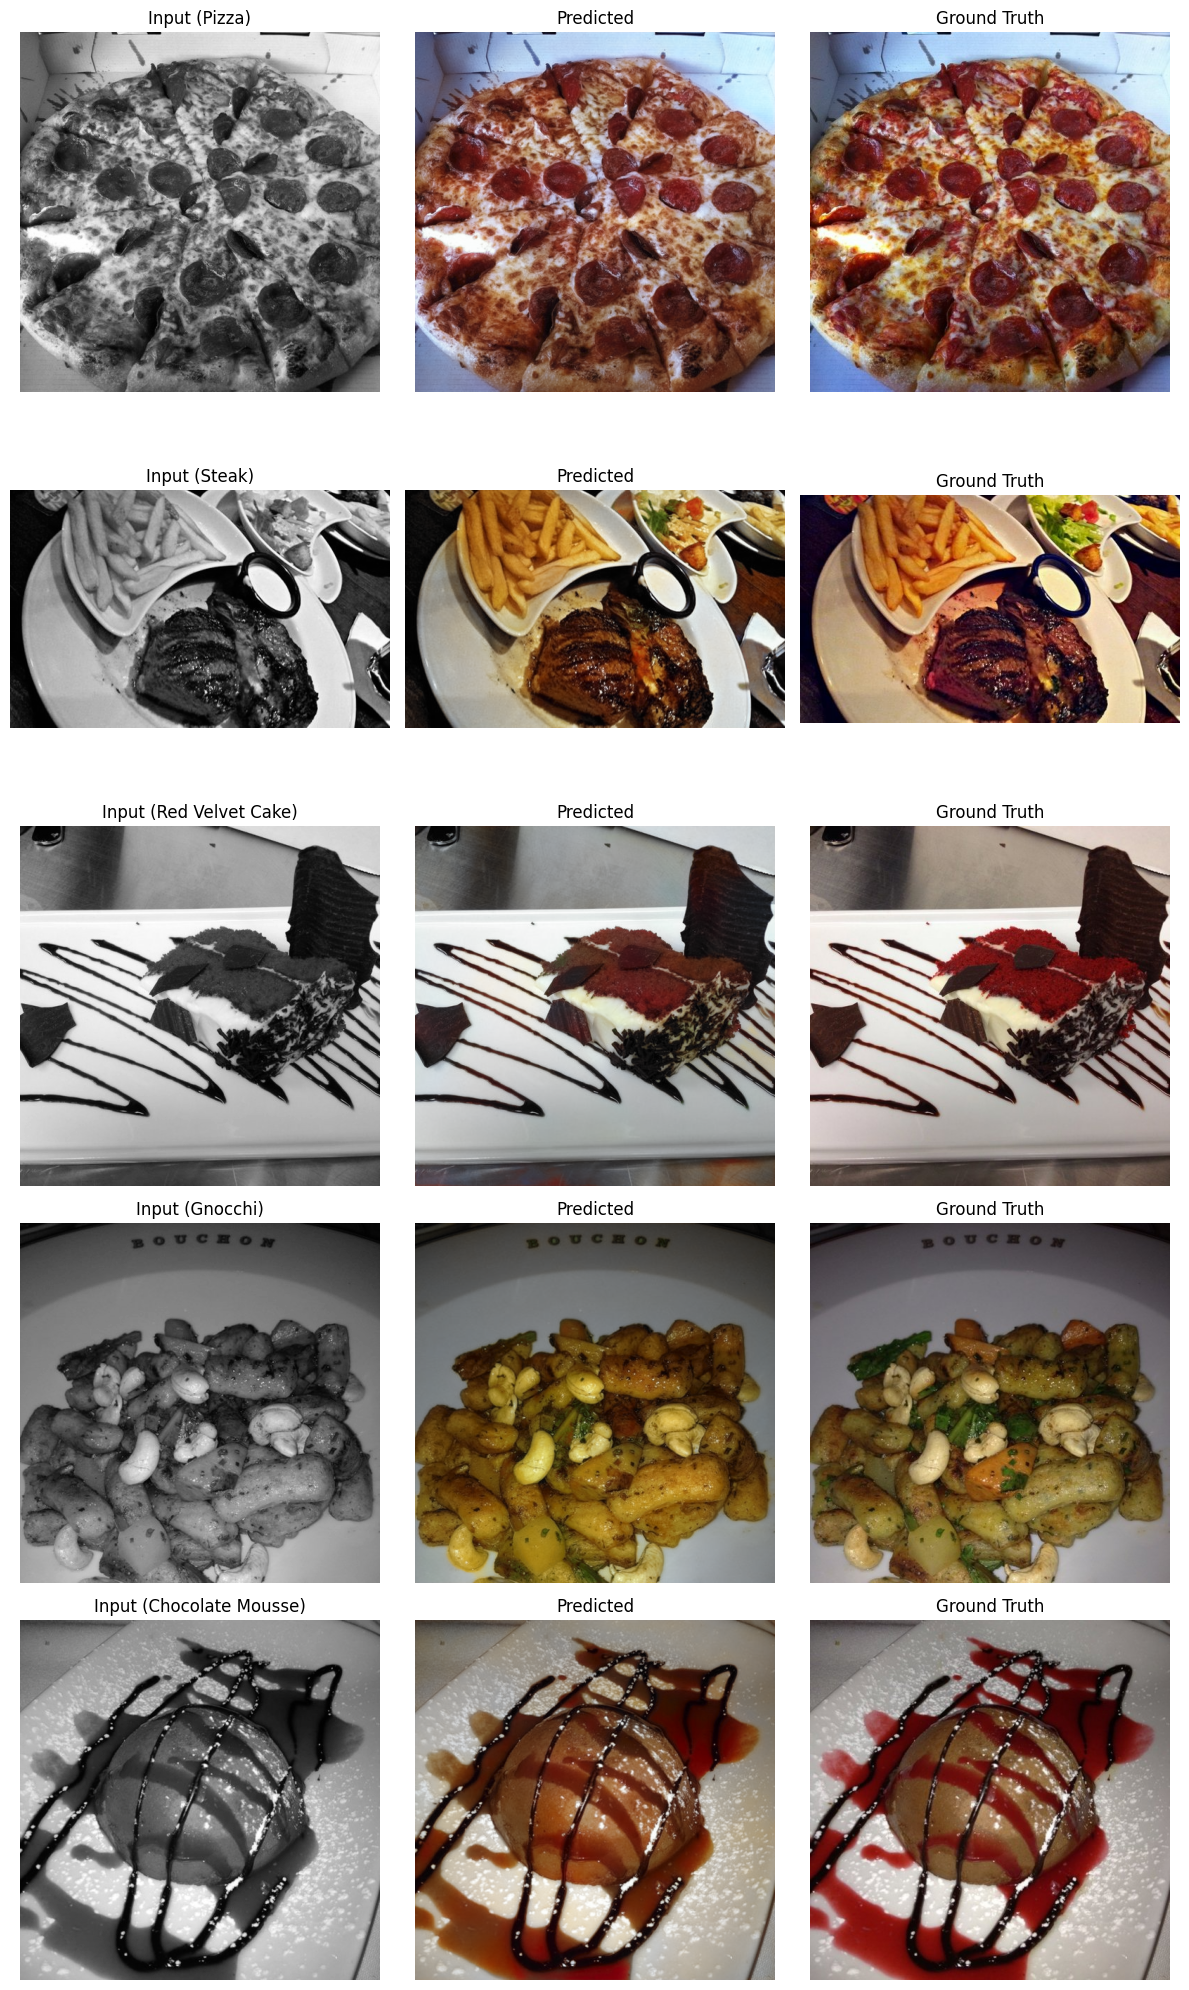

In [4]:
test_images_dir = Path("data/food-101/images")

def get_label(p):
    return p.parent.name.replace("_", " ").title()

# Select multiple test images from different categories
test_samples = [
    test_images_dir / "pizza" / "1001116.jpg",
    test_images_dir / "steak" / "1094883.jpg",
    test_images_dir / "red_velvet_cake" / "3632882.jpg",
    test_images_dir / "gnocchi" / "1239821.jpg",
    test_images_dir / "chocolate_mousse" / "1169204.jpg",
]
for p in test_samples:
    assert is_in_testset(p), f"NOT in official test split: {p}"
print("all selected images are in the official test split")
# Filter existing files
test_samples = [p for p in test_samples if p.exists()][:6]
# Colorize all images
results_1 = []
for img_path in test_samples:
    result = inference_mgr.colorize_image(img_path, temperature=cfg.config['inference']['temperature_default'])
    results_1.append({
        'path': img_path,
        'L': result['L'],
        'rgb': result['rgb'],
        'gt': Image.open(img_path).convert('RGB')
    })
# Create comparison grid
n_images = len(results_1)
fig, axes = plt.subplots(n_images, 3, figsize=(12, 4*n_images))
if n_images == 1:
    axes = axes[np.newaxis, :]
for i, result in enumerate(results_1):
    label = get_label(result['path'])

    axes[i, 0].imshow(result['L'], cmap='gray')
    axes[i, 0].set_title(f'Input ({label})', fontsize=12)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(result['rgb'])
    axes[i, 1].set_title('Predicted', fontsize=12)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(result['gt'])
    axes[i, 2].set_title('Ground Truth', fontsize=12)
    axes[i, 2].axis('off')

    # row label on the left
plt.tight_layout()
plt.savefig("outputs/colorization_comparison_1.png", dpi=300)
plt.show()

all selected images are in the official test split


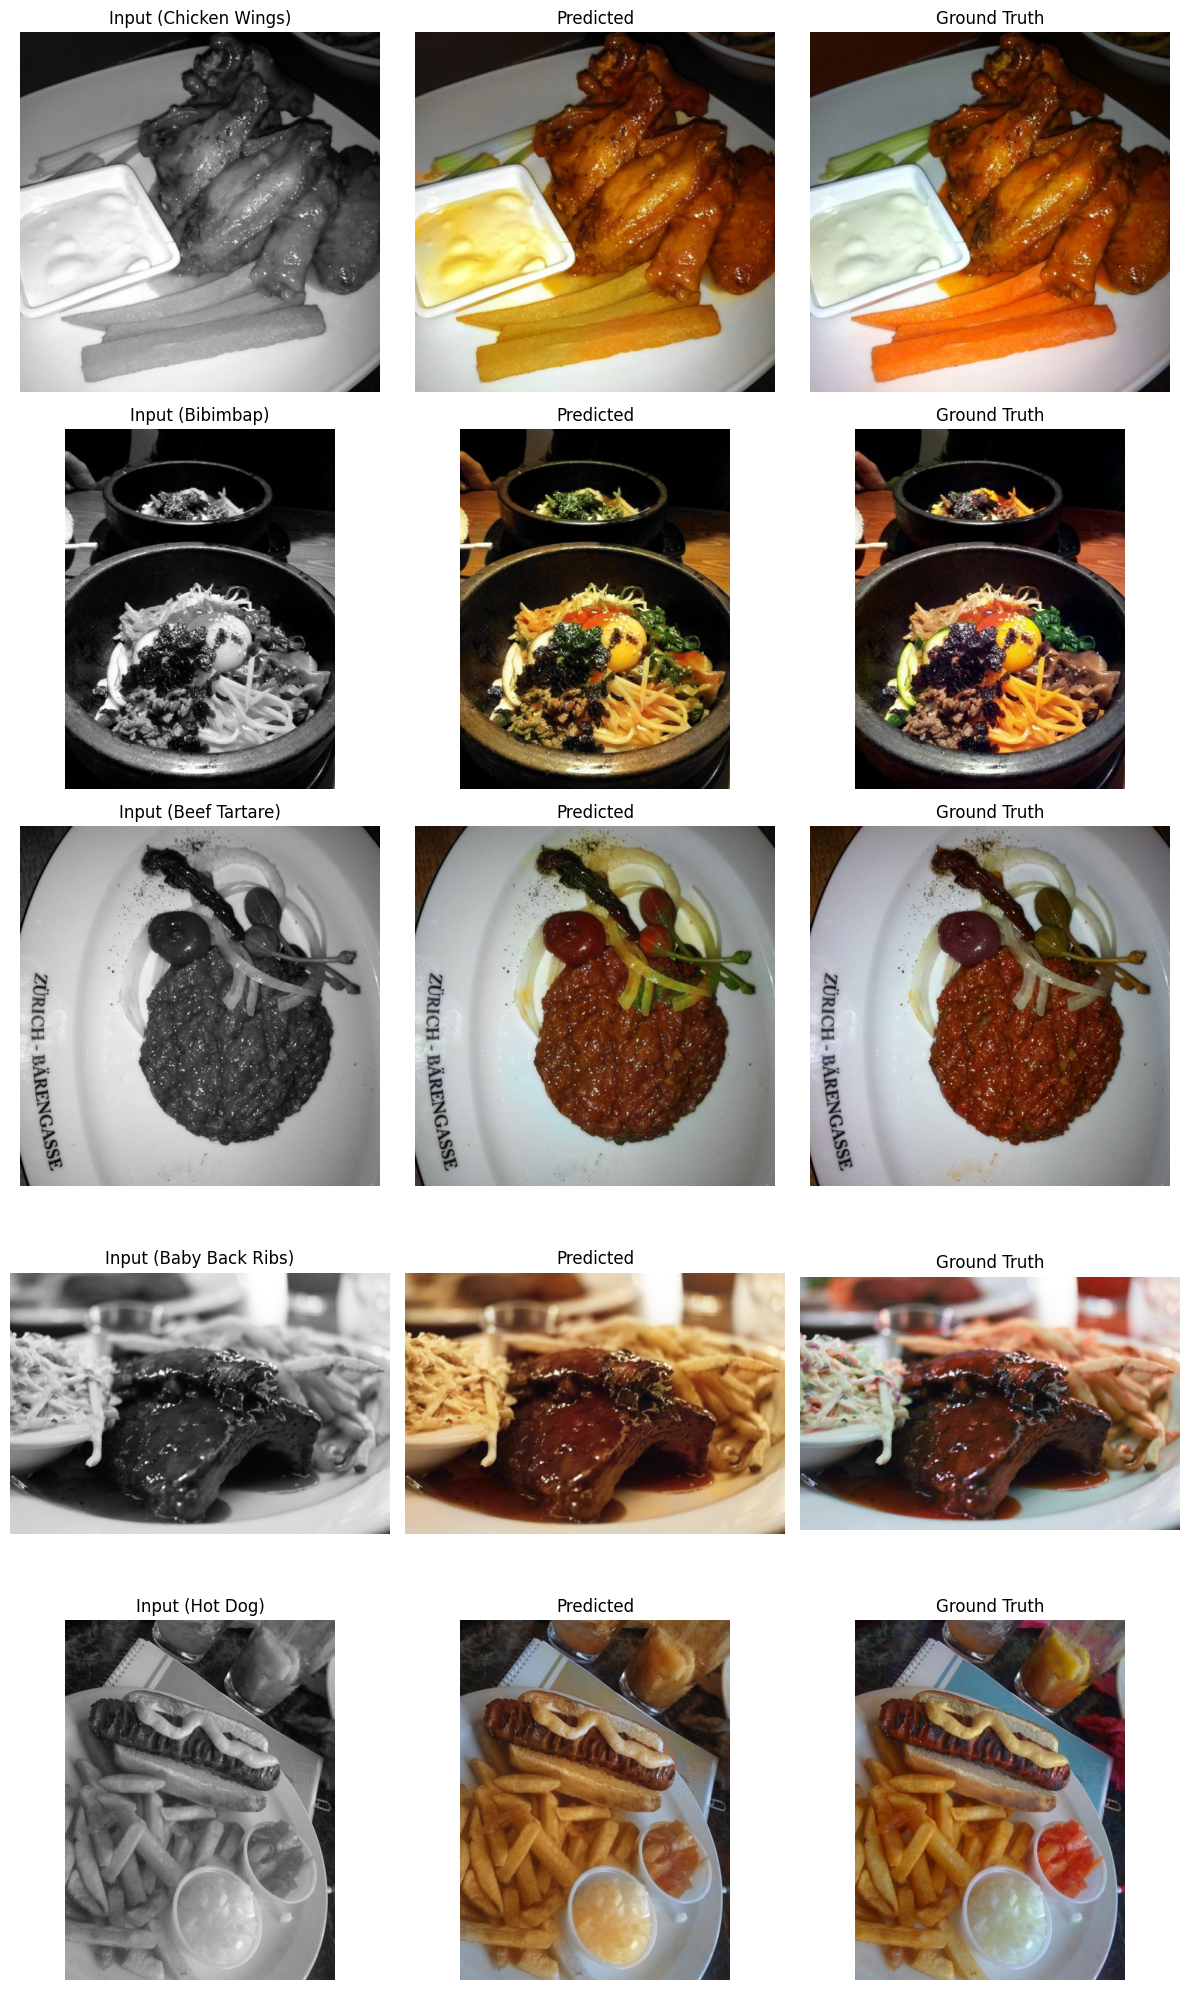

In [5]:


# Select multiple test images from different categories
test_samples = [
    test_images_dir / "chicken_wings" / "1036790.jpg",
    test_images_dir / "bibimbap" / "1018560.jpg",
    test_images_dir / "beef_tartare" / "1151854.jpg",
    test_images_dir / "baby_back_ribs" / "1183551.jpg",
    test_images_dir / "hot_dog" / "67755.jpg",

]
# Filter existing files
test_samples = [p for p in test_samples if p.exists()][:6]
for p in test_samples:
    assert is_in_testset(p), f"NOT in official test split: {p}"
print("all selected images are in the official test split")
# Colorize all images
results_2 = []
for img_path in test_samples:
    result = inference_mgr.colorize_image(img_path, temperature=cfg.config['inference']['temperature_default'])
    results_2.append({
        'path': img_path,
        'L': result['L'],
        'rgb': result['rgb'],
        'gt': Image.open(img_path).convert('RGB')
    })
# Create comparison grid
n_images = len(results_2)
fig, axes = plt.subplots(n_images, 3, figsize=(12, 4*n_images))
if n_images == 1:
    axes = axes[np.newaxis, :]
for i, result in enumerate(results_2):
    label = get_label(result['path'])

    axes[i, 0].imshow(result['L'], cmap='gray')
    axes[i, 0].set_title(f'Input ({label})', fontsize=12)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(result['rgb'])
    axes[i, 1].set_title('Predicted', fontsize=12)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(result['gt'])
    axes[i, 2].set_title('Ground Truth', fontsize=12)
    axes[i, 2].axis('off')

    # row label on the left
plt.tight_layout()
plt.savefig("outputs/colorization_comparison_2.png", dpi=300)
plt.show()

In [6]:
results = results_1 + results_2 
# Compute metrics for test images
metrics_computer = PerceptualMetrics(
    device=cfg.device,
    use_lpips=True,
    use_ssim=True,
    use_psnr=True
)
print("Computing metrics for test images...\n")
all_metrics = []
for result in results:
    # Get predicted RGB
    pred_rgb_np = result['rgb']  # (H, W, 3) in [0, 1]
    # Get ground truth and resize to match prediction size
    gt_pil = result['gt']  # PIL Image
    pred_h, pred_w = pred_rgb_np.shape[:2]
    # Resize GT to match prediction size
    gt_pil_resized = gt_pil.resize((pred_w, pred_h), Image.BICUBIC)
    gt_rgb_np = np.array(gt_pil_resized) / 255.0  # (H, W, 3) in [0, 1]
    # Convert to tensors (float32)
    pred_rgb = torch.from_numpy(pred_rgb_np).float().permute(2, 0, 1).unsqueeze(0).to(cfg.device)
    gt_rgb = torch.from_numpy(gt_rgb_np).float().permute(2, 0, 1).unsqueeze(0).to(cfg.device)
    # Compute metrics
    metrics = metrics_computer.compute_batch_metrics(pred_rgb, gt_rgb)
    # Add filename
    metrics['image'] = result['path'].parent.name + '/' + result['path'].name
    all_metrics.append(metrics)
# Display as table
df = pd.DataFrame(all_metrics)
df = df[['image', 'lpips', 'ssim', 'psnr']]  # Reorder columns
print(df.to_string(index=False))
print(f"\nAverage Metrics:")
print(f"  LPIPS: {df['lpips'].mean():.4f}")
print(f"  SSIM:  {df['ssim'].mean():.4f}")
print(f"  PSNR:  {df['psnr'].mean():.2f} dB")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/p25w03/.conda/envs/foodcolor/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
LPIPS model (alex) loaded successfully
Computing metrics for test images...

                       image    lpips     ssim      psnr
           pizza/1001116.jpg 0.145409 0.951476 25.012745
           steak/1094883.jpg 0.124800 0.897283 23.217590
 red_velvet_cake/3632882.jpg 0.079180 0.971349 28.337822
         gnocchi/1239821.jpg 0.113450 0.948223 26.903723
chocolate_mousse/1169204.jpg 0.112903 0.943795 28.027187
   chicken_wings/1036790.jpg 0.139510 0.910783 21.732885
        bibimbap/1018560.jpg 0.131763 0.910147 24.271893
    beef_tartare/1151854.jpg 0.075822 0.960781 28.489725
  baby_back_ribs/1183551.jpg 0.171989 0.925163 21.028185
           hot_dog/67755.jpg 0.164860 0.935359 23.743862

Average Metrics:
  LPIPS: 0.1260
  SSIM:  0.9354
  PSNR:  25.08 dB


In [10]:

# ----------------------------
# config
# ----------------------------
root = Path("data/food-101")
images_root = root / "images"
test_list_file = root / "meta" / "test.txt"
out_dir = Path("outputs")
out_dir.mkdir(parents=True, exist_ok=True)

TEMPERATURE = cfg.config['inference']['temperature_default']

# Set to an int for a quick smoke test (e.g. 200). Set to None for full test set.
LIMIT = None 

# ----------------------------
# helpers
# ----------------------------
def save_benchmark_summary_png(df, out_path, title=None, figsize=(10, 5)):
    """
    Creates a professional vertical benchmark table.
    Red text is used if the score does not meet the 'Target (Good)'.
    """
    # Pulling means from the summary dataframe
    psnr_val = df['psnr mean'].iloc[0]
    ssim_val = df['ssim mean'].iloc[0]
    lpips_val = df['lpips mean'].iloc[0]

    # Data structure: [Metric Name, Value, Good Threshold, Great Threshold]
    data = [
        ["PSNR (↑)", psnr_val, 20.0, 25.0],
        ["SSIM (↑)", ssim_val, 0.80, 0.90],
        ["LPIPS (↓)", lpips_val, 0.20, 0.10],
    ]
    
    # Prepare text for the table cells
    display_rows = []
    for label, val, good, great in data:
        target_good = f"> {good:.2f}" if "↑" in label else f"< {good:.2f}"
        target_great = f"> {great:.2f}" if "↑" in label else f"< {great:.2f}"
        display_rows.append([label, f"{val:.2f}", target_good, target_great])

    bench_df = pd.DataFrame(display_rows, columns=["Metric", "Our Score", "Target (Good)", "Target (Great)"])

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    
    if title:
        ax.set_title(title, fontsize=16, weight='bold', pad=30)

    table = ax.table(
        cellText=bench_df.values,
        colLabels=bench_df.columns,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 3.5) 

    header_bg = "#3b4252"  
    metric_col_bg = "#e5e9f0"

    for (r, c), cell in table.get_celld().items():
        if r == 0:
            cell.set_text_props(weight="bold", color="white")
            cell.set_facecolor(header_bg)
        elif r > 0:
            label, val, threshold, _ = data[r-1]
            
            # Metric column styling
            if c == 0:
                cell.set_facecolor(metric_col_bg)
                cell.set_text_props(weight="bold")
            
            # Logic for Red Color (Bad Result) in 'Our Score' column
            if c == 1:
                is_bad = False
                if "↑" in label and val < threshold:
                    is_bad = True
                elif "↓" in label and val > threshold:
                    is_bad = True
                
                text_color = "#c0392b" if is_bad else "#2e3440"
                cell.set_text_props(weight="bold", color=text_color)
            
            # Zebra striping for other columns
            if r % 2 == 0 and c != 0:
                cell.set_facecolor("#f8f9fa")

    plt.tight_layout()
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

def save_styled_class_table_png(df, out_path, title=None, figsize=(12, 8)):
    """
    Saves the per-class metrics table with directional arrows and 2-decimal precision.
    """
    df_plot = df.copy()
    
    # Rename columns for clarity
    column_mapping = {
        "lpips mean": "LPIPS (↓)",
        "ssim mean": "SSIM (↑)",
        "psnr mean": "PSNR (↑)"
    }
    df_plot = df_plot.rename(columns=column_mapping)
    
    # Format floats to 2 decimals
    for col in df_plot.columns:
        if pd.api.types.is_float_dtype(df_plot[col]):
            df_plot[col] = df_plot[col].map(lambda x: f"{x:.2f}")

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    
    if title:
        ax.set_title(title, fontsize=14, weight='bold', pad=20)

    table = ax.table(
        cellText=df_plot.values,
        colLabels=df_plot.columns,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.1, 2.2) 

    header_color = "#2c3e50"
    
    for (r, c), cell in table.get_celld().items():
        if r == 0:
            cell.set_text_props(weight="bold", color="white")
            cell.set_facecolor(header_color)
        elif r > 0:
            if r % 2 == 0:
                cell.set_facecolor("#f9f9f9")
            
            col_name = df_plot.columns[c]
            if "(↓)" in col_name:
                cell.set_text_props(color="#2980b9", weight="bold")
            elif "(↑)" in col_name:
                color = "#27ae60" if "SSIM" in col_name else "#d300a5"
                cell.set_text_props(color=color, weight="bold")

    plt.tight_layout()
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

def get_class(rel_no_suffix: str) -> str:
    return rel_no_suffix.split("/", 1)[0]

# ----------------------------
# build test paths from official split
# ----------------------------
test_rel = [x.strip() for x in test_list_file.read_text().splitlines() if x.strip()]
if LIMIT is not None:
    test_rel = test_rel[:int(LIMIT)]

test_paths = [images_root / (r + ".jpg") for r in test_rel]
missing = [p for p in test_paths if not p.exists()]
if missing:
    raise FileNotFoundError(f"{len(missing)} images not found. Example: {missing[0]}")

print(f"Testing {len(test_paths)} images...")

# ----------------------------
# metrics computer initialization
# ----------------------------
metrics_computer = PerceptualMetrics(
    device=cfg.device,
    use_lpips=True,
    use_ssim=True,
    use_psnr=True
)

# ----------------------------
# run full test inference + metrics
# ----------------------------
all_metrics = []
device = cfg.device

for i, img_path in enumerate(test_paths, 1):
    # Inference
    result = inference_mgr.colorize_image(img_path, temperature=TEMPERATURE)
    pred_rgb_np = result["rgb"]

    # Ground Truth preparation
    gt_pil = Image.open(img_path).convert("RGB")
    pred_h, pred_w = pred_rgb_np.shape[:2]
    gt_pil_resized = gt_pil.resize((pred_w, pred_h), Image.BICUBIC)
    gt_rgb_np = np.array(gt_pil_resized, dtype=np.float32) / 255.0

    # Tensor conversion
    pred_rgb = torch.from_numpy(pred_rgb_np).float().permute(2, 0, 1).unsqueeze(0).to(device)
    gt_rgb   = torch.from_numpy(gt_rgb_np).float().permute(2, 0, 1).unsqueeze(0).to(device)

    m = metrics_computer.compute_batch_metrics(pred_rgb, gt_rgb)

    # Store data
    rel_no_suffix = img_path.relative_to(images_root).with_suffix("").as_posix()
    all_metrics.append({
        "image": rel_no_suffix,
        "class": get_class(rel_no_suffix),
        "lpips": float(m.get("lpips", np.nan)),
        "ssim":  float(m.get("ssim", np.nan)),
        "psnr":  float(m.get("psnr", np.nan)),
    })

    if i % 50 == 0 or i == len(test_paths):
        print(f"Progress: {i}/{len(test_paths)}")

df = pd.DataFrame(all_metrics)

# ----------------------------
# Generate Final Outputs
# ----------------------------
# 1. Summary Statistics
summary_df = pd.DataFrame([{
    "lpips mean": df["lpips"].mean(),
    "ssim mean": df["ssim"].mean(),
    "psnr mean": df["psnr"].mean(),
}])

save_benchmark_summary_png(
    summary_df, 
    out_dir / "reconstruction_benchmarks_final.png", 
    title=f"Food-101 Overall Quality (T={TEMPERATURE})"
)

# 2. Per-Class Performance
by_class = df.groupby("class")[["lpips", "ssim", "psnr"]].mean().reset_index()
by_class.columns = ["class", "lpips mean", "ssim mean", "psnr mean"]
by_class = by_class.sort_values("psnr mean", ascending=False)

# Adjust height based on number of classes
dynamic_h = max(4.0, 0.6 * len(by_class))
save_styled_class_table_png(
    by_class, 
    out_dir / "test_metrics_by_class_final.png", 
    title="Per-Class Mean Scores", 
    figsize=(12, dynamic_h)
)

print(f"\nEvaluation complete. Results saved in: {out_dir}")

Testing 25250 images...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/p25w03/.conda/envs/foodcolor/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
LPIPS model (alex) loaded successfully
Progress: 50/25250
Progress: 100/25250
Progress: 150/25250
Progress: 200/25250
Progress: 250/25250
Progress: 300/25250
Progress: 350/25250
Progress: 400/25250
Progress: 450/25250
Progress: 500/25250
Progress: 550/25250
Progress: 600/25250
Progress: 650/25250
Progress: 700/25250
Progress: 750/25250
Progress: 800/25250
Progress: 850/25250
Progress: 900/25250
Progress: 950/25250
Progress: 1000/25250
Progress: 1050/25250
Progress: 1100/25250
Progress: 1150/25250
Progress: 1200/25250
Progress: 1250/25250
Progress: 1300/25250
Progress: 1350/25250
Progress: 1400/25250
Progress: 1450/25250
Progress: 1500/25250
Progress: 1550/25250
Progress: 1600/25250
Progress: 1650/25250
Progress: 1700/25250
Progress: 1750/25250
Progress: 1800/25250
Progress: 1850/252

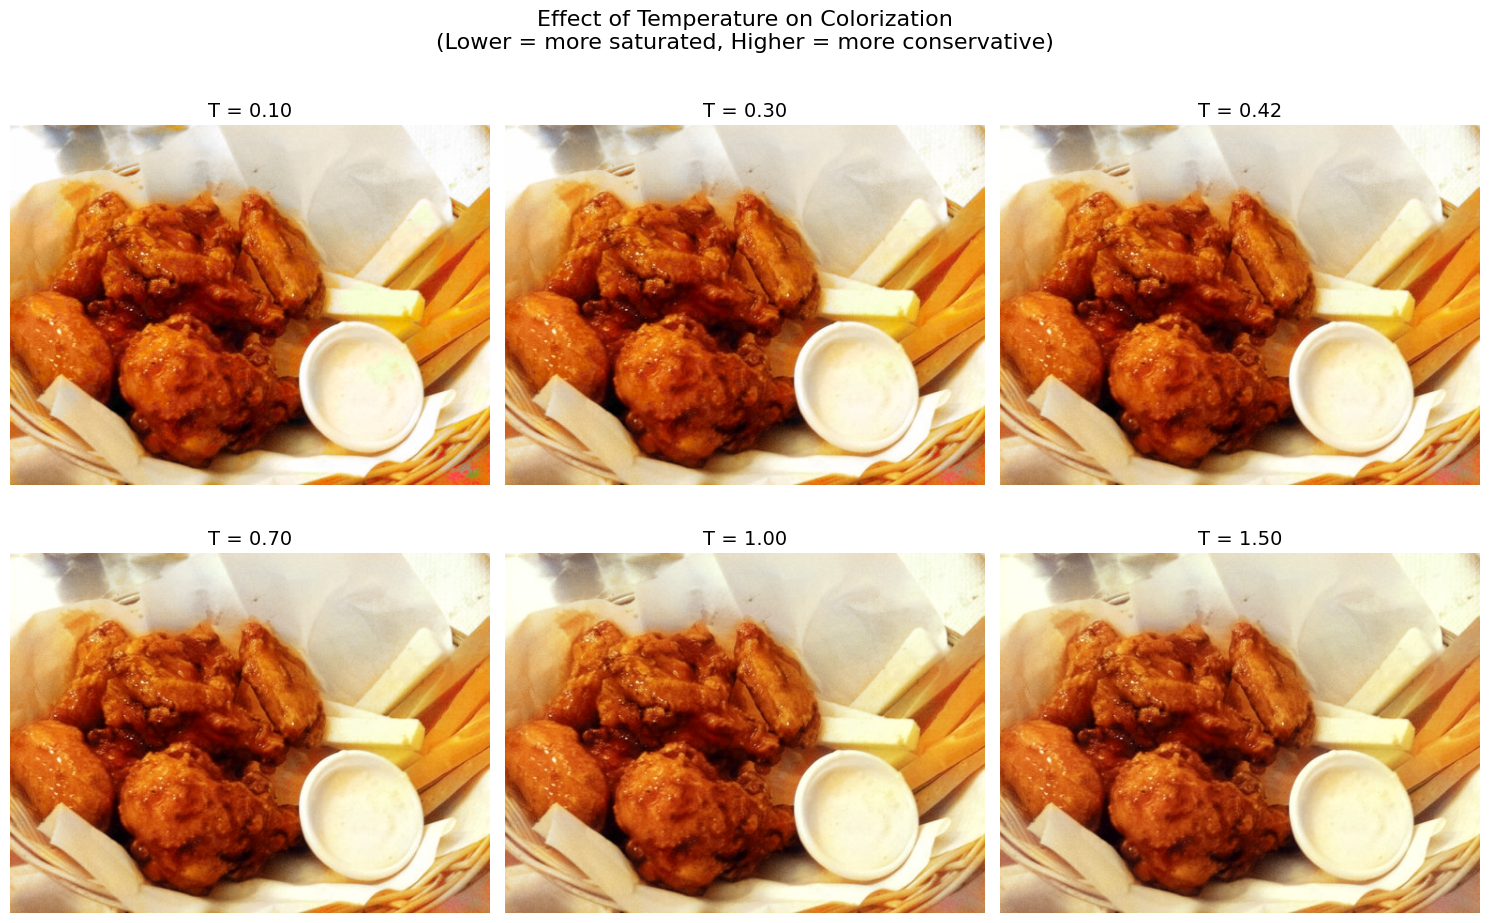

In [6]:
# Compare different temperatures side-by-side
temperatures = [0.1, 0.3, 0.42, 0.7, 1.0, 1.5]
sample_img = test_samples[0]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, temp in enumerate(temperatures):
    result = inference_mgr.colorize_image(sample_img, temperature=temp)
    axes[i].imshow(result['rgb'])
    axes[i].set_title(f'T = {temp:.2f}', fontsize=14)
    axes[i].axis('off')
plt.suptitle('Effect of Temperature on Colorization\n(Lower = more saturated, Higher = more conservative)',
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [7]:
# Video colorization example
# Place a test video in ../data/test_video.mp4

video_input = Path("data/test_video.mp4")
video_output = Path("outputs/colorized_video.mp4")
video_output.parent.mkdir(exist_ok=True)

if video_input.exists():
    print(f"Colorizing video: {video_input}")
    print("This may take a few minutes depending on video length...")

    colorize_video(
        video_path=video_input,
        output_path=video_output,
        inference_manager=inference_mgr,
        temperature=0.42,
        target_fps=10,
        create_gif=True,  # Also create animated GIF
        keep_frames=False
    )

    print(f"✓ Video saved to: {video_output}")
    print(f"✓ GIF saved to: {video_output.with_suffix('.gif')}")
else:
    print(f"Video not found at {video_input}")
    print("To test video colorization, place a video file at the path above.")

Colorizing video: data/test_video.mp4
This may take a few minutes depending on video length...
Video Colorization Pipeline
Input: data/test_video.mp4
Output: outputs/colorized_video.mp4

Step 1: Extracting frames
----------------------------------------------------------------------
Extracting frames from: test_video.mp4
  Original: 24.00 fps, 192 frames, 1280x720
  Sampling: every 2 frame(s)
  Total extracted: 96 frames

Step 2: Colorizing frames
----------------------------------------------------------------------
  Colorized 50/96 frames...
  Total colorized: 96 frames

Step 3: Assembling output video
----------------------------------------------------------------------
Assembling video: colorized_video.mp4
  96 frames at 10 fps
  Resolution: 1024x576
  Video saved: outputs/colorized_video.mp4

Step 4: Creating animated GIF
----------------------------------------------------------------------
Creating comparison GIF: colorized_video.gif
  96 frames at 10 fps
  Layout: Grayscale |